# PRETRAIN FROM PERSONALLY TRAINED MODEL
## FastAI Cassava Root Disease Classification

In [1]:

## PREVIOUS BEST WITH ACC = 0.87
# RUN_NAME_OF_MODEL_TO_LOAD = '20210210-1221 - arch=tf_efficientnet_b4_ns - samples=1800 frozen=1 epochs=40 bs=8 res=480'
# EPOCH_TO_LOAD = 1


In [2]:
# RUN_NAME_OF_MODEL_TO_LOAD = '20210217-1008 - arch=densenetblur121d - samples=650 frozen=1 epochs=60 bs=32 res=300'
# EPOCH_TO_LOAD = 9

<br>
<br>

In [3]:

from datetime import datetime
import fastai
TEST = False
ARCH = 'densenetblur121d'  # resnet101
CHOSEN_SAMPLE_SIZE = -1  # 10000 #-1 # 650 #1000  #1800  # use this to control per-category sample sizes # 1000  # deprecated but not removed
TEST_SET_SIZE = round(CHOSEN_SAMPLE_SIZE * 0.2)  # number of images per category to put in the test set
FROZEN_EPOCHS = 1  # 1
EPOCHS = 5  # 4
BATCH_SIZE = 32  # 16
RESOLUTION=300
PRETRAINED_FLAG = True  # actually False - just to make sure we train a few times before attempting to find LR
GRAD_ACC = 128 # set this to 64 when testing with low data.  Set it to 128, 192 or 256 when using lots of data.

VALID_PERC = 0.2

# data = ''
# rn_addon = f'_data={data}'

time = datetime.today().strftime("%Y%m%d-%H%M")

RUN_NAME = f'{time} - arch={ARCH} - samples={CHOSEN_SAMPLE_SIZE} frozen={FROZEN_EPOCHS} epochs={EPOCHS} bs={BATCH_SIZE} res={RESOLUTION}'

print(f"RUN_NAME = '{RUN_NAME}'")

RUN_NAME = '20210225-0246 - arch=densenetblur121d - samples=-1 frozen=1 epochs=5 bs=32 res=300'


In [4]:
import sys
sys.path.append('../utils')

from fastbook import *
from fastai.vision.all import *
from fastai.vision.widgets import *
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
from string import ascii_uppercase
import numpy as np
import operator
import glob

import torch
from torch import nn as nn
from torch.nn import functional as F

import gc
from cassava_utils import *
from pip_augs import *
from augmentation import *

%matplotlib inline
# %matplotlib widget

plt.rcParams['figure.figsize'] = [9, 5]
plt.rcParams['figure.dpi'] = 120
plt.style.use('dark_background')

import warnings
warnings.filterwarnings('ignore')  # or 'once'  


data_path = Path('../../data')


In [5]:
show_cuda_status()

CUDA available:              True
CUDA device count:           1
Current CUDA Device index:   0
Current CUDA Device:         GeForce RTX 2070 SUPER

fastai version:              2.2.7
cuda version:                11.0
torch version:               1.7.0


<br>
<br>

### Load the Data

In [6]:
classes = ['cbb', 'cbsd', 'cgm', 'cmd', 'healthy']

In [7]:

if TEST:
    df = pd.read_csv(f'{data_path}/sample_submission.csv')
else: 
    df = pd.read_csv(f'{data_path}/all_train_files.csv')

cols = df.columns.tolist()
cols = cols[::-1]
df = df[cols]
if not TEST and CHOSEN_SAMPLE_SIZE > 0:
    df = df.sample(n=CHOSEN_SAMPLE_SIZE, replace=False)  # random sample
df.head()

,label,image_id
0,0,train-cbb-188.jpg
1,0,train-cbb-255.jpg
2,0,train-cbb-273.jpg
3,0,train-cbb-13.jpg
4,0,train-cbb-76.jpg


<br>
<br>

## Create a subset of the data to test on and train ensembles on.  AKA Working Validation Set

In [8]:
# Stratified subset
ensemble_train_df = df.groupby('label', group_keys=False).apply(lambda x: x.sample(frac=0.16426))

# drop the subset rows
df = df.drop(index=ensemble_train_df.index)

# shuffle and reset index
ensemble_train_df = ensemble_train_df.sample(len(ensemble_train_df)).reset_index(drop=True)
df = df.sample(len(df)).reset_index(drop=True)

# Re-order the dataframes
df = pd.DataFrame({'image_id':df.image_id, 'label':df.label})
ensemble_train_df = pd.DataFrame({'image_id':ensemble_train_df.image_id, 'label':ensemble_train_df.label})

len(df), len(ensemble_train_df)

(20348, 4000)

<br>
<br>

## Check the Distribution for Imbalance

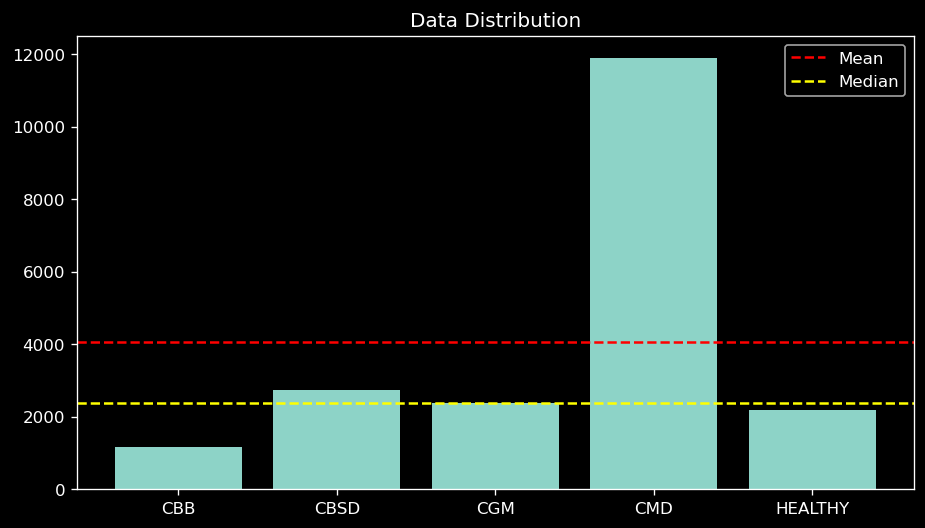

In [9]:
cat_names = ['CBB', 'CBSD', 'CGM', 'CMD', 'HEALTHY']
plt.bar(cat_names, df.loc[:,'label'].value_counts(sort=False))
plt.axhline(df.loc[:,'label'].value_counts().mean(), color='red', ls='--', label='Mean')
plt.axhline(df.loc[:,'label'].value_counts().median(), color='yellow', ls='--', label='Median')
plt.title('Data Distribution')
plt.legend()
plt.show()

<br>
<br>

## Calculate the Relative Weights

In [10]:
from sklearn.utils.class_weight import compute_class_weight
weights = compute_class_weight('balanced', classes=[0,1,2,3,4], y=df.label)
print(f'Relative Weights: {weights}\n\n')

plt.bar(cat_names, weights)
plt.axhline(np.mean(weights), color='red', ls='--', label='Mean')
plt.axhline(np.median(weights), color='yellow', ls='--', label='Median')
plt.title('Computed Relative Weights')
plt.legend()
plt.show()

Relative Weights: [3.48424658 1.48960469 1.71279461 0.34209818 1.87022059]




KeyboardInterrupt: 

<br>
<br>

## Hand Tune the outlier weights

In [ ]:
tuned_weights = weights.copy()
tuned_weights[0] = tuned_weights[0] * 0.6
tuned_weights[3] = tuned_weights[3] * 1.7

plt.bar(cat_names, tuned_weights)
plt.axhline(np.mean(weights), color='red', ls='--', label='Old Mean')
plt.axhline(np.median(weights), color='yellow', ls='--', label='Old Median')
plt.title('Tuned Relative Weights')
plt.legend()
plt.show()

<br>
<br>

## Calculate the new Weighted Distribution

In [ ]:
weighted_dist = tuned_weights * df.loc[:,'label'].value_counts(sort=False)

plt.bar(cat_names, weighted_dist)
plt.axhline(df.loc[:,'label'].value_counts().mean(), color='red', ls='--', label='Old Mean')
plt.axhline(df.loc[:,'label'].value_counts().median(), color='yellow', ls='--', label='Old Median')
plt.axhline(np.mean(weighted_dist), color='blue', ls='--', label='NEW Mean')
plt.axhline(np.median(weighted_dist), color='green', ls='--', label='NEW Median')
plt.title('Weighted Data Distribution')
plt.legend()
plt.show()

In [ ]:
# convert the tuned weights to a tensor
tuned_weights = Tensor(tuned_weights).cuda()
tuned_weights

<br>
<br>

## Create a list of image paths

In [ ]:
train_imgs = L([Path(data_path/'train_images'/f) for f in df.image_id])
random.shuffle(train_imgs)

In [ ]:
ensemble_train_imgs = L([Path(data_path/'train_images'/f) for f in ensemble_train_df.image_id])
random.shuffle(ensemble_train_imgs)

<br>
<br>

### Create the DataLoaders

In [ ]:
# get the label from any image path  @TODO sloooooowwwwww......

def get_label(o):
    fname = o.name
    if fname in df.image_id.values:
        return df[df.image_id == fname].label.values[0]
    if fname in ensemble_train_df.image_id.values:
        return ensemble_train_df[ensemble_train_df.image_id == fname].label.values[0]


<br>
<br>

## Create the Transforms

In [ ]:
item_tfms = [ToTensor(), AlbumentationsTransform(get_train_aug(RESOLUTION), get_valid_aug(RESOLUTION))]
batch_tfms = [IntToFloatTensor(), Normalize.from_stats(*imagenet_stats)]

<br>
<br>

## Create the Splitter

In [ ]:
start_val = len(train_imgs) - int(len(train_imgs) * VALID_PERC)
idcs = list(range(start_val, len(train_imgs)))
splitter = IndexSplitter(idcs)
splits = splitter(train_imgs)
split_list = [splits[0], splits[1]]

split_list.append(L(range(len(train_imgs), len(train_imgs)+len(ensemble_train_imgs))))


In [ ]:
split_list

In [ ]:
split_list[0][0], split_list[0][-1], split_list[1][0], split_list[1][-1], split_list[2][0]

<br>
<br>

## Create the Data Loaders

In [ ]:
dsrc = Datasets(train_imgs+ensemble_train_imgs, tfms=[[PILImage.create], [get_label, Categorize]],
                splits = split_list)

dls = dsrc.dataloaders(bs=BATCH_SIZE, after_item=item_tfms, after_batch=batch_tfms)

In [ ]:
train_labels = list(df.label.values)
train_labels.extend(ensemble_train_df.label.values)

<br>

### Verify the Training and Validation Batches

In [ ]:
print('examples from the training set')
dls.train.show_batch(max_n=8, nrows=2)

In [ ]:
print('\nexamples from the validation set')
dls.valid.show_batch(max_n=8, nrows=2)

<br>
<br>

## Create our Callbacks

In [ ]:
cutmix_cb, mixup_cb = None, None

def create_callbacks():

    # Eary stopping callback
    early_stop_cb = EarlyStoppingCallback(monitor='valid_loss', min_delta=0.001, patience=4, reset_on_fit=False)

    # Save the current model's weights every epoch
    save_cb = SaveModelCallback(fname=RUN_NAME, with_opt=True)

    # Reduce the Learning Rate if valid_loss flatlines
    reduceLR_cb = ReduceLROnPlateau(monitor='valid_loss', min_delta=0.01, min_lr=1e-8, patience=2, factor=10, reset_on_fit=False)

    # Mixup callback for regularization
    # mixup_cb = MixUp(alpha=0.3)
    mixup_cb = None

    # Cutmix callback for regularization
    cutmix_cb = CutMix(alpha=1.0)
    # cutmix_cb = None

    # Gradient Accumulation
    # gradacc_cb =  GradientAccumulation(n_acc=16)
    gradacc_cb =  GradientAccumulation(n_acc=64)
  
    # log our runs
    csv_log_cb = CSVLogger(fname=f'CSV-History/{RUN_NAME}.csv', append=True)


    # List of callbacks to be used later
    cbs = [save_cb, ShowGraphCallback(), early_stop_cb, GradientClip, gradacc_cb]  #, csv_log_cb] #, reduceLR_cb]

    if mixup_cb != None:
        cbs.insert(0, mixup_cb)

    if cutmix_cb != None:
        cbs.insert(0, cutmix_cb)

    print('\nAll Callbacks: ', cbs)
    
    return cbs

### Visualize the effect of CutMix


In [ ]:
if cutmix_cb != None:
    with Learner(dls, nn.Linear(3,4), loss_func=CrossEntropyLossFlat(), cbs=cutmix_cb) as learn:
        learn.epoch,learn.training = 0,True
        learn.dl = dls.train
        b = dls.one_batch()
        learn._split(b)
        learn('before_batch')

    _,axs = plt.subplots(3,3, figsize=(9,9))
    dls.show_batch(b=(cutmix_cb.x,cutmix_cb.y), ctxs=axs.flatten())
    
else: print('\n CutMix was not selected.')

<br>

### Visualize the Effect of MixUp

MixUp creates a linear interpolation between the target data and another datapoint.  In images, it shows up as ghostly figures.  The technique has been shown to be a good to decrease the liklihood of overfitting.

In [ ]:
if mixup_cb != None:
    with Learner(dls, nn.Linear(3,4), loss_func=CrossEntropyLossFlat(), cbs=mixup_cb) as learn:
        learn.epoch,learn.training = 0,True
        learn.dl = dls.train
        b = dls.one_batch()
        learn._split(b)
        learn('before_batch')

    _,axs = plt.subplots(3,3, figsize=(9,9))
    dls.show_batch(b=(mixup_cb.x,mixup_cb.y), ctxs=axs.flatten())

else: print('\n MixUp was not selected.')

In [ ]:
import timm

def create_learner(cat_weights=None):
    # Create the learner
    learn = timm_learner(dls, 
                         ARCH,
                         opt_func=ranger,
                         loss_func=LabelSmoothingCrossEntropyFlat(weight=cat_weights),
                         cbs=create_callbacks(), 
                         pretrained=PRETRAINED_FLAG,
                         metrics = [error_rate, accuracy, RocAuc()]
                        )


    # Learner Surgery - replacing modules
    learn = convert_MP_to_blurMP(learn, nn.MaxPool2d)  # doesn't exist!
    learn.model = convert_act_cls(learn.model, nn.ReLU, MishAuto())  # very expensive so we only use it on the head
#     learn.model = convert_act_cls(learn.model, nn.SiLU, SwishAuto())  # replace with a lower memory version
    
#     learn = learn.to_fp16()  # convert to 16bit
    learn = learn.to_non_native_fp16()

    return learn


In [ ]:
learn = create_learner()

In [ ]:
display(learn.loss_func, learn.opt_func, learn.cbs) #, '-------------------------------------', learn.model)  # Checkpoint

In [ ]:
learn.model[1]

In [ ]:
# # RUN_NAME_OF_MODEL_TO_LOAD = '20210211-0115 - arch=tf_efficientnet_b4_ns - samples=1800 frozen=1 epochs=15 bs=12 res=460'
# EPOCH_TO_LOAD = 7

# load_model(f'models/{RUN_NAME_OF_MODEL_TO_LOAD}.pth', learn, opt=ranger, with_opt=True)



# <br>
<br>
<br>
<br>

# ------------------ RUN TO HERE -------------------

<br>
<br>
<br>

## Find a Good Learning Rate to Start With

In [ ]:
LR_DIV = 14e0  # Shift the lr_min left by this amount.  Adjust as necessary
lr_min = 0.002  # just a default

In [ ]:
# from apex.fp16_utils import convert_network
# learn.model = convert_network(learn.model, torch.float16)

In [ ]:
# learn = learn.to_fp16()

In [ ]:
if PRETRAINED_FLAG == True:
    learn.freeze()
    lr_min,lr_steep = learn.lr_find()
    plt.axvline(lr_min, ls='--', color='red', label=f'lr_min={round(lr_min,6)}')
    plt.axvline(lr_min/LR_DIV, ls='--', color='yellow', label=f'lr_min / {LR_DIV}={round(lr_min/LR_DIV,6)}')
    plt.axvline(lr_steep, ls='--', color='grey', label=f'lr_steep={round(lr_steep,6)}')
    plt.legend()
    plt.show()

    print(f"Minimum/10: {lr_min:.2e}, steepest point: {lr_steep:.2e}, (Mim/10)/{LR_DIV}: {lr_min/LR_DIV}")

<br>
<br>

# Pick a Good Initial Learning Rate

In [ ]:
# LR_CHOICE = lr_min/LR_DIV
# LR_CHOICE = lr_steep
# LR_CHOICE = 9e-3
# LR_CHOICE = 2e-4
LR_CHOICE = min(3e-2, lr_min)
# LR_CHOICE=1e-3

<br>
<br>

<br>
<br>

# Training the Model

<br>

## Fit the last layers, unfreeze, fit the whole net, with a decent initial LR, all in one go.



In [ ]:
if PRETRAINED_FLAG:
    print(f'FROZEN_EPOCHS:  {FROZEN_EPOCHS}')
print(f'EPOCHS:         {EPOCHS}')
print(f'Learning Rate:  {LR_CHOICE}\n\n')

In [ ]:
if PRETRAINED_FLAG:
    learn.fit_flat_cos(FROZEN_EPOCHS, LR_CHOICE, pct_start=0.99, wd=0.1, reset_opt=True)
#     fit_hump(learn, 1, lr_max=LR_CHOICE, reset_opt=True)
#     learn.fit_one_cycle(FROZEN_EPOCHS, slice(LR_CHOICE), wd=0.1)

    print(f'Max GPU Memory Allocated: {torch.cuda.max_memory_allocated()/1000000000} GB')
    torch.cuda.reset_max_memory_allocated()

<br>
<br>

## Manually set up the unfrozen runs

In [ ]:
learn.unfreeze()

In [ ]:
lr_min,lr_steep = learn.lr_find()
plt.axvline(lr_min, ls='--', color='red', label=f'lr_min={round(lr_min,6)}')
# plt.axvline(LR_CHOICE/2, ls='--', color='yellow', label=f'LR_CHOICE/2={round(LR_CHOICE/2,6)}')
plt.axvline(lr_steep, ls='--', color='grey', label=f'lr_steep={round(lr_steep,6)}')
plt.axvline(2e-5, ls='--', color='green', label=f'{round(2e-5,6)}')
plt.axvline(7e-5, ls='--', color='orange', label=f'{round(7e-5,6)}')

plt.legend()
plt.show()

In [ ]:
print(f"Minimum/10: {lr_min:.2e}, steepest point: {lr_steep:.2e}")  #, LR_CHOICE/2: {LR_CHOICE / 2}")

In [ ]:
# Persist a Copy

# Need to do this first as it won't pickle
# learn.remove_cbs(CSVLogger)

learn.export(f'models/STAGE1_{RUN_NAME}.pkl')
print(f'Saved to: models/STAGE1_{RUN_NAME}.pkl')

# put the logger back in
# learn.add_cbs(CSVLogger(fname=f'{RUN_NAME}.csv', append=True))

## Pick a new Learning Rate

In [ ]:
# LR_CHOICE_UNFROZ = 9e-3
# LR_CHOICE_UNFROZ = 3e-3
# LR_CHOICE_UNFROZ = 4e-3
# LR_CHOICE_UNFROZ = 6e-3
# LR_CHOICE_UNFROZ = 5e-4
LR_CHOICE_UNFROZ = 2e-3



### Train

In [ ]:
EPOCHS = 30

In [ ]:
print(f'EPOCHS:         {EPOCHS}')
print(f'Learning Rate:  {LR_CHOICE_UNFROZ}\n\n')

In [ ]:
# learn.fit_flat_cos(EPOCHS, slice(LR_CHOICE_UNFROZ), pct_start=0.68)

# learn.fit_one_cycle(EPOCHS, slice(LR_CHOICE_UNFROZ),  wd=1e-2)

learn.fit_flat_cos(EPOCHS, LR_CHOICE_UNFROZ, pct_start=0.1, wd=1e-2, reset_opt=False)
# fit_hump(learn, EPOCHS, lr_max=LR_CHOICE_UNFROZ, reset_opt=True)

print(f'Max GPU Memory Allocated: {torch.cuda.max_memory_allocated()/1000000000} GB')
torch.cuda.reset_max_memory_allocated()

In [ ]:
learn.recorder.plot_sched()

In [ ]:
learn.save(f'{RUN_NAME}_model1_acc{round(learn.validate(ds_idx=2)[2],2)}')

<br>
<br>

# Cross-Validate + Ensemble

In [ ]:
from sklearn.model_selection import StratifiedKFold

LR_CHOICE_UNFROZ = 8e-4
EPOCHS = 5

skf = StratifiedKFold(n_splits=5, random_state = 42, shuffle=True)
i = 0
tw_flag = None
val_pct = []
tst_preds = []

record_df = pd.DataFrame(columns=['RUN_NAME', 'split num', 'epoch', 'loss', 'accuracy', 'roc_auc', 'tuned weights bool'])

for _, val_idx in skf.split(np.array(train_imgs+ensemble_train_imgs), train_labels):
    i += 1
    
    print('\n\n\n')
    print(f'-----------------------------------')
    print(f'------------ SPLIT {i} ------------')
    print(f'-----------------------------------')

    # sort out the data
    splits = IndexSplitter(val_idx)
    split = splits(train_imgs)
    split_list = [split[0], split[1]]
    split_list.append(L(range(len(train_imgs), len(train_imgs)+len(ensemble_train_imgs))))
    dsrc = Datasets(train_imgs+ensemble_train_imgs, tfms=[[PILImage.create], [get_label, Categorize]],
                  splits=split_list)
    dls = dsrc.dataloaders(bs=BATCH_SIZE, after_item=item_tfms, after_batch=batch_tfms)

    # Create a brand new learner model each time
    if torch.rand(1)[0] > 0.5:
        learn = create_learner(cat_weights=tuned_weights)
        tw_flag = True
    else:
        learn = create_learner(cat_weights=None)
        tw_flag = False
     
    # fit just the new head
    learn.freeze()
    learn.fit_flat_cos(FROZEN_EPOCHS, LR_CHOICE, pct_start=0.99, wd=0.1, reset_opt=True)
    learn.unfreeze()
    
    # persist
#     learn.remove_cbs(CSVLogger)  # temp
    learn.export(f'models/{RUN_NAME}_split_{i}.pkl')
    learn.save(f'{RUN_NAME}_STAGE1_split{i}_acc{round(learn.validate(ds_idx=2)[2],2)}')
    print(f'Saved to: ../models/{RUN_NAME}_split_{i}.pkl')
#     CSVLogger(fname=f'{RUN_NAME}.csv', append=True)  # restore


    # fit a series of short-run models to ensemble later.  Also simulates cos annealing with warm restarts
    for ep in range(5, 30, 5):
        
        print(f'\n\n------> EPOCH: {ep-5} - {ep}')
        
        if ep <= 15:
            learn.fit_flat_cos(EPOCHS, LR_CHOICE_UNFROZ, pct_start=0.38, wd=1e-2, reset_opt=False)
        elif ep == 20:
            learn.fit_flat_cos(EPOCHS, LR_CHOICE_UNFROZ/10, pct_start=0.38, wd=1e-2, reset_opt=False)
        elif ep == 25 
            learn.fit_flat_cos(EPOCHS+3, LR_CHOICE_UNFROZ/100, pct_start=0.38, wd=1e-2, reset_opt=False)

            
               
        # save 
        learn.save(f'{RUN_NAME}_split_{i}_epoch{ep}_acc{round(learn.validate(ds_idx=2)[2],2)}')
        
        # save stats
        val = learn.validate()
        record_df.loc[len(record_df.index)] = [RUN_NAME, i, ep, val[0], val[2], val[3], tw_flag]
        record_df.to_csv(f'CSV-History/{RUN_NAME}_record.csv')
        
        # print validation info
#         print(f'Validation on train: {learn.validate(0)}')
#         print(f'Validation on valid: {val}')
        print(f'Validation on test: {learn.validate(2)}')
   
#     learn.recorder.plot_sched()
    
    # Save the validation information to cross validate with
    val_pct.append(learn.validate()[2])
    a,b = learn.get_preds(ds_idx=2)
    tst_preds.append(a)

<br>
<br>

<br>

# -------------------- TRAIN AGAIN -----------------

<br>

<br>
<br>

### Train again

In [ ]:
# save_model("test.pth", learn, learn.opt, with_opt=True)

In [ ]:
# learn = load_learner(f'../models/{RUN_NAME}.pkl', cpu=False)
#
    # RUN_NAME_OF_MODEL_TO_LOAD = '20210210-2234 - arch=tf_efficientnet_b4_ns - samples=1800 frozen=1 epochs=15 bs=12 res=460'
    # EPOCH_TO_LOAD = 9

# load_model(f'models/{RUN_NAME_OF_MODEL_TO_LOAD}_{EPOCH_TO_LOAD}.pth', learn, opt=ranger, with_opt=False)

# load_model(f'models/{RUN_NAME}_8.pth', learn, opt=ranger, with_opt=True)
# learn = load_learner(f'../models/{RUN_NAME}.pkl', cpu=False)
# load_model(f'test.pth', learn, opt=ranger, with_opt=True)

# load_model(f'models/20210213-2138 - arch=efficientnet_b3a - samples=1800 frozen=3 epochs=60 bs=32 res=400_9.pth', learn, opt=ranger, with_opt=True)

learn.dls = dls
learn.remove_cbs(cbs)
learn.add_cbs(cbs)

learn.opt.clear_state()


In [ ]:
learn.unfreeze()

In [ ]:
# learn.dls = dls_findlr
lr_min,lr_steep = learn.lr_find()
plt.axvline(lr_min, ls='--', color='red', label=f'lr_min={round(lr_min,6)}')
# plt.axvline(LR_CHOICE/2, ls='--', color='yellow', label=f'LR_CHOICE/2={round(LR_CHOICE/2,6)}')
plt.axvline(lr_steep, ls='--', color='grey', label=f'lr_steep={round(lr_steep,6)}')
plt.axvline(2e-5, ls='--', color='green', label=f'{round(2e-5,6)}')
plt.axvline(7e-5, ls='--', color='orange', label=f'{round(7e-5,6)}')

plt.legend()
plt.show()


learn.dls = dls
del dls_findlr
gc.collect()
torch.cuda.empty_cache()
gc.collect()


In [ ]:
EPOCHS = 20
LR_CHOICE_UNFROZ = 7e-3

In [ ]:
print(f'EPOCHS:         {EPOCHS}')
print(f'Learning Rate:  {LR_CHOICE_UNFROZ}\n\n')

In [ ]:
# learn.fit_flat_cos(EPOCHS, slice(LR_CHOICE_UNFROZ), pct_start=0.68)

# learn.fit_flat_cos(EPOCHS, LR_CHOICE_UNFROZ, pct_start=0.2, wd=0.1) # , reset_opt=True)
fit_hump(learn, EPOCHS, lr_max=LR_CHOICE_UNFROZ, reset_opt=False)

print(f'Max GPU Memory Allocated: {torch.cuda.max_memory_allocated()/1000000000} GB')
torch.cuda.reset_max_memory_allocated()

<br>
<br>

## Persist the Model

In [ ]:
learn.export(f'../models/{RUN_NAME}.pkl')
print(f'Saved to: ../models/{RUN_NAME}.pkl')

# path = Path('../models')
# path.ls(file_exts='.pkl')

<br>
<br>

### Show some Results

In [ ]:
learn.show_results()


<br>
<hr>
<br>
<br>
<br>

# Validation Set (not test set) Analysis

<br>

### Plot Losses

In [ ]:
# learn.recorder.plot_loss()
# plt.ylabel('Loss')
# plt.xlabel('Batches Processed')

In [ ]:
c = learn.cbs

In [ ]:
learn.remove_cbs(c)
learn.to_non_native_fp16()

In [ ]:
learn.remove_cbs(NonNativeMixedPrecision)

In [ ]:
learn.cbs

In [ ]:
learn.add_cbs(NonNativeMixedPrecision)

<br>

### Visualize with a confusion Matrix

In [ ]:
interp = ClassificationInterpretation.from_learner(learn)
interp.plot_confusion_matrix(figsize=(8,8))

In [ ]:
interp.most_confused()[:10]

<br>
<br>

## Classification Report

In [ ]:
interp.print_classification_report()

<br>

### Show the top 15 most error prone images

In [ ]:
interp.plot_top_losses(15, nrows=5)

<br>
<br>
<br>
<br>

# ----------------- Validation ------------

<br>
<br>

<br>

In [ ]:
VALID_RESOLUTION = 400
VALID_BATCH_SIZE = 12

test_learn = learn

# load_learner('../models/{RUN_NAME}.pkl', cpu=False)
# load_model(f'models/{RUN_NAME_OF_MODEL_TO_LOAD}.pth', test_learn, opt=ranger, with_opt=True)


In [ ]:
def get_train_aug_test(): return A.Compose([
            A.RandomResizedCrop(VALID_RESOLUTION,VALID_RESOLUTION, scale=(0.2, 1)),
            A.Transpose(p=0.7),
            A.HorizontalFlip(p=0.5),
            A.VerticalFlip(p=0.5),
            A.ShiftScaleRotate(p=0.7),
            A.HueSaturationValue(
                hue_shift_limit=0.3, 
                sat_shift_limit=0.3, 
                val_shift_limit=0.3, 
                p=0.7
            ),
            A.RandomBrightnessContrast(
                brightness_limit=(-0.2,0.2), 
                contrast_limit=(-0.2, 0.2), 
                p=0.7
            ),
            A.CoarseDropout(p=0.8, max_holes=20),
            A.Cutout(p=0.8, max_h_size=12, max_w_size=12),
            A.Sharpen(p=0.3, alpha=(0.1,0.3), lightness=(0.3, 0.9))
], p=1.0)



def get_valid_aug_test(): return A.Compose([
    A.Resize(VALID_RESOLUTION, VALID_RESOLUTION, p=1.0),
    A.OneOf([
        A.CenterCrop(VALID_RESOLUTION,VALID_RESOLUTION, always_apply=True),
        A.RandomResizedCrop(VALID_RESOLUTION,VALID_RESOLUTION, scale=(0.4, 0.7), always_apply=True),

        ], p=1.0),
        A.Resize(VALID_RESOLUTION, VALID_RESOLUTION, p=1.0),

            A.HorizontalFlip(p=0.5),

        A.HueSaturationValue(
            hue_shift_limit=0.14, 
            sat_shift_limit=0.14, 
            val_shift_limit=0.14, 
            p=0.5
            ),
        A.RandomBrightnessContrast(
            brightness_limit=(-0.15,0.15), 
            contrast_limit=(-0.1, 0.2), 
            p=0.5
            ),
    A.Sharpen(p=1, alpha=(0.1, 0.3), lightness=(0.3, 0.9))
], p=1.0)

In [ ]:
def get_test_fnames(path):
    return ensemble_train_imgs

In [ ]:
learn.validate(ds_idx=2)

In [ ]:
test_dls = ImageDataLoaders.from_df(ensemble_train_df, folder=data_path/'train_images', seed=42, label_col = 0, fn_col=0, 
                               batch_tfms=batch_tfms, bs=BATCH_SIZE, item_tfms=item_tfms)
test_dl = test_dls.test_dl(ensemble_train_df)

####  Get the Inferrences on the Test Set

In [ ]:
inputs, preds, targs, decoded, losses = test_learn.get_preds(dl=test_dl, with_input=True, with_decoded=True, with_loss=True, reorder=False)


In [ ]:
interp = ClassificationInterpretation(dl=test_dl, inputs=inputs, preds=preds, targs=targs, decoded=decoded, losses=losses )

<br>

### Visualize with a confusion Matrix

In [ ]:
interp.plot_confusion_matrix(figsize=(8,8))

In [ ]:
interp.most_confused()[:10]

<br>
<br>

## Classification Report

In [ ]:
interp.print_classification_report()

In [ ]:
interp.plot_top_losses(k=15)

## Archive this version of the notebook

In [ ]:
import os
import shutil

# Allow Jupyter the opportunity to autosave
!sleep 20
# time = '20210122-2356'
# copy the notebook file - the prefix links it to the saved model
shutil.copyfile('DenseNet Cassava Disease Classification-Copy1.ipynb', f'Archive/{time} - DenseNet Cassava Disease Classification.ipynb')

## Infer on the Kaggle provided test set

In [ ]:
predstta, targstta = test_learn.tta(dl=test_dl, n=3)  #, use_max=False, beta=0.1)
# print(classification_report(df.iloc[:,0], preds.argmax(dim=-1).numpy()))  # TTA

In [ ]:
from sklearn.metrics import classification_report
from sklearn.metrics import accuracy_score

print(classification_report(predstta.argmax(dim=-1), targstta))

# FIND ALL WRONG FILES

In [ ]:
def get_test_fnames(path):
    return all_files

item_tfms = [AlbumentationsTransform(get_train_aug_test(), get_valid_aug_test())]
batch_tfms = [Normalize.from_stats(*imagenet_stats)]

test_db = DataBlock(
    blocks=(ImageBlock, CategoryBlock), 
    get_items=get_test_fnames,
    get_y=parent_label, 
    item_tfms=item_tfms,
    batch_tfms=batch_tfms)

dls = test_db.dataloaders(get_test_fnames, bs=VALID_BATCH_SIZE)

test_dl = dls.test_dl(get_test_fnames('None'), with_labels=True)

allpreds, alltargs, alldecoded = test_learn.get_preds(dl=test_dl, with_decoded=True)

In [ ]:
inacc_flist = []

for i in range(len(alltargs)):
    if int(alltargs[i]) != int(alldecoded[i]):
        inacc_flist.append(test_dl.items[i])
        
print(f'Number of inaccurate inferrences: {len(inacc_flist)}')
print(f'Percent Accurate:  {1 - (len(inacc_flist) / len(alltargs))}')

        

In [ ]:
from sklearn.metrics import classification_report
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix

print(classification_report(alltargs, allpreds.argmax(dim=-1)))
# confusion_matrix(alltargs, allpreds.argmax(dim=-1))

In [ ]:
import pickle
with open(f"INACCFLIST_{RUN_NAME_OF_MODEL_TO_LOAD}.p", "wb") as pfile:
    pickle.dump(inacc_flist, pfile)

In [ ]:
test_learn.predict('../data/test_images/2216849948.jpg')